In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.fft as fft
import matplotlib.pyplot as plt
from misc import show_imset, ZernikeBasis
import scipy.io as sio
import tifffile
from scipy.ndimage import rotate

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [2]:
def xyzs_for_crlb(xyzs, dx, dy, dz):
    nz = xyzs.shape[0]
    crlb_xyzs = xyzs.repeat(4, 1)
    crlb_xyzs[1 * nz:2 * nz, 0] = crlb_xyzs[1 * nz:2 * nz, 0] + dx
    crlb_xyzs[2 * nz:3 * nz, 1] = crlb_xyzs[2 * nz:3 * nz, 1] + dy
    crlb_xyzs[3 * nz:4 * nz, 2] = crlb_xyzs[3 * nz:4 * nz, 2] + dz
    return crlb_xyzs

def crlb_calculator(psfs, nz, dx, dy, dz, beta):

    psfs0 = psfs[:1 * nz, 0, :, :]
    dpdx = (psfs[1 * nz:2 * nz, 0, :, :] - psfs0) / dx
    dpdy = (psfs[2 * nz:3 * nz, 0, :, :] - psfs0) / dy
    dpdz = (psfs[3 * nz:4 * nz, 0, :, :] - psfs0) / dz
    dxx = torch.sum(dpdx * dpdx / (psfs0 + beta + 1e-9), dim=(1, 2), keepdim=True)
    dxy = torch.sum(dpdx * dpdy / (psfs0 + beta + 1e-9), dim=(1, 2), keepdim=True)
    dxz = torch.sum(dpdx * dpdz / (psfs0 + beta + 1e-9), dim=(1, 2), keepdim=True)

    dyy = torch.sum(dpdy * dpdy / (psfs0 + beta + 1e-9), dim=(1, 2), keepdim=True)
    dyz = torch.sum(dpdy * dpdz / (psfs0 + beta + 1e-9), dim=(1, 2), keepdim=True)

    dzz = torch.sum(dpdz * dpdz / (psfs0 + beta + 1e-9), dim=(1, 2), keepdim=True)

    finfo = torch.cat((torch.cat((dxx, dxy, dxz), dim=2),
                       torch.cat((dxy, dyy, dyz), dim=2),
                       torch.cat((dxz, dyz, dzz), dim=2)),
                      dim=1)

    crlb = torch.sqrt(torch.diagonal(torch.linalg.inv(finfo), dim1=1, dim2=2)) * 1e6  # um
    return crlb

def TV(M):
    return (M[1:, :] - M[:-1, :]).pow(2).sum() + (M[:, 1:] - M[:, :-1]).pow(2).sum()


class PSFModel(nn.Module):
    def __init__(self, checkpoint):
        super(PSFModel, self).__init__()
        device = checkpoint['device']
        z2zc = checkpoint['z2zc']
        z2zc.load_state_dict(checkpoint['z2zc_state_dict'])
        # for parameter in z2zc.parameters():
        #     parameter.requires_grad = False
        self.z2zc = z2zc.to(device)
        self.mask = checkpoint['mask'].to(device)
        self.blur_kernel = checkpoint['blur_kernel'].to(device)
        
        self.znms = checkpoint['znms'].to(device)
        self.aper = checkpoint['aper'].to(device)
        self.xgrid, self.ygrid = checkpoint['xgrid'].to(device), checkpoint['ygrid'].to(device)
        self.idx_defocus = checkpoint['idx_defocus']
        self.N_aper, self.N = checkpoint['N_aper'], checkpoint['N']
        
        self.idx05 = int(checkpoint['N']/2)
        self.w05 = 75
        
    def forward(self, xyzs):
        xy, z = (xyzs[:, :2]), (xyzs[:, 2]).unsqueeze(1)
        xy_phase = (xy[:, 0]).unsqueeze(1).unsqueeze(1) * self.xgrid + (xy[:, 1]).unsqueeze(1).unsqueeze(1) * self.ygrid

        zc = self.z2zc(z)  # Bx1--> Bxzn
        z_phase = torch.sum(self.znms[self.idx_defocus:self.idx_defocus + 1, :, :] * (
            zc[:, self.idx_defocus:self.idx_defocus + 1]).unsqueeze(2).unsqueeze(2), dim=1)
        
        uin = self.aper * torch.exp(1j * (z_phase + xy_phase + self.mask))
        uout = fft.fftshift(fft.fftn(fft.ifftshift(uin, dim=(1, 2)), dim=(1, 2)), dim=(1, 2))
        psf = torch.abs(uout) ** 2
        psf = psf.unsqueeze(1).type(torch.float32)
        # # crop
        psf = psf[:, :, self.idx05 - self.w05:self.idx05 + self.w05 + 1, self.idx05 - self.w05:self.idx05 + self.w05 + 1]
        # blur
        psf = F.conv2d(psf, self.blur_kernel.unsqueeze(0).unsqueeze(0), padding=int(self.blur_kernel.shape[0]/2))
        # photon normalization
        psf = psf / torch.sum(psf, dim=(2, 3), keepdim=True) * 1e4  # rank 4
        
        return psf
           

In [3]:
checkpoint = torch.load('checkpoint.pt')
checkpoint['device'] = device
model = PSFModel(checkpoint)

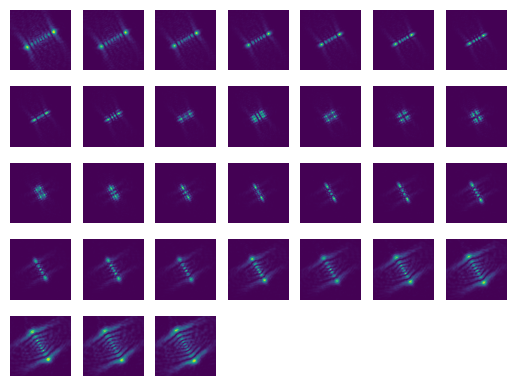

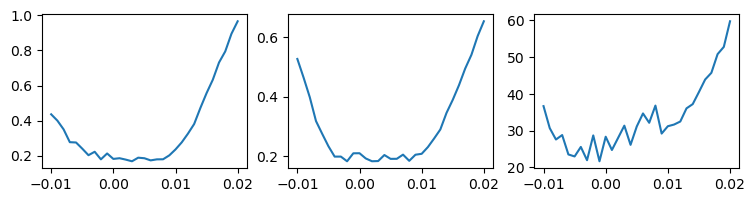

In [4]:
zmin = -0.01
zmax = 0.02

zs = torch.arange(zmin, zmax+1e-9, 1e-3, device=device)
nz = zs.shape[0]
xyzs = zs.unsqueeze(1).repeat(1, 3)
xyzs[:, :2] = 0.0

dx, dy, dz = 1e-8, 1e-8, 1e-6
beta = 10
crlb_xyzs = xyzs_for_crlb(xyzs, dx, dy, dz)

with torch.set_grad_enabled(False):
    
    psfs0 = model(crlb_xyzs)
    crlb0 = crlb_calculator(psfs0, nz, dx, dy, dz, beta)
    
    show_imset(psfs0.cpu()[:nz, 0, :,:])
    plt.figure(figsize=(9, 2))
    plt.subplot(1, 3, 1)
    plt.plot(zs.cpu(), crlb0.cpu()[:, 0])
    plt.subplot(1, 3, 2)
    plt.plot(zs.cpu(), crlb0.cpu()[:, 1])
    plt.subplot(1, 3, 3)
    plt.plot(zs.cpu(), crlb0.cpu()[:, 2])
    plt.show()
    
 

In [5]:
N = model.N
N_aper = model.N_aper
zernike = ZernikeBasis(N_aper)
znms = zernike.polynomials(8)
znms = znms[3:] # ignore z00
before = int((N-N_aper)/2)
after = N-N_aper-before
znms = np.pad(znms, ((0, 0), (before, after), (before, after)))
znms = torch.tensor(znms, device=device)
zc = torch.zeros(znms.shape[0], device=device, requires_grad=True)

seed = 11 # 11
torch.manual_seed(seed)
np.random.seed(seed)
optimizer = torch.optim.Adam([{'params':zc, 'lr':5e-2}])

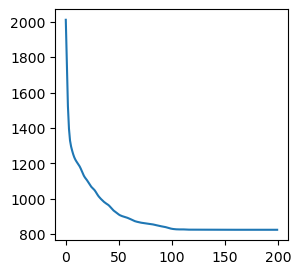

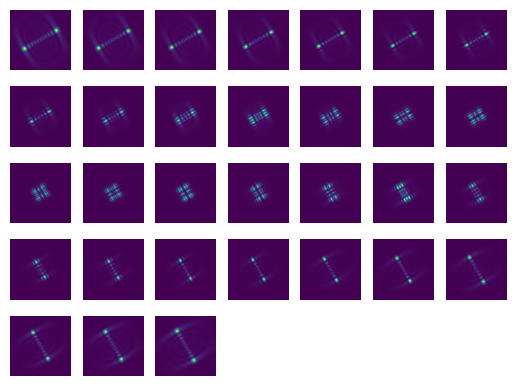

In [6]:
epoch_loss = []
for i in range(200):
    model.mask = torch.sum(znms*zc.unsqueeze(1).unsqueeze(1), dim=0)
    psfs1 = model(crlb_xyzs)
    crlb1 = crlb_calculator(psfs1, nz, dx, dy, dz, beta)
    
    loss = torch.sum(crlb1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    epoch_loss.append(loss.item())

plt.figure(figsize=(3, 3))
plt.plot(epoch_loss)
plt.show()

show_imset(psfs1.detach().cpu()[:1*nz, 0, :, :])

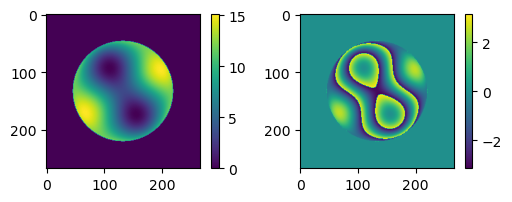

In [7]:
phase = model.mask.detach().cpu().numpy()
phase = (phase-phase.min())*model.aper.cpu().numpy()
phase = phase[150:-150, 150:-150]

phase_wrap = np.angle(np.exp(1j*phase))
plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.imshow(phase)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(phase_wrap)
plt.colorbar()
plt.show()

crlb1 = crlb1.detach().cpu()

mask = model.mask.detach().cpu().numpy()


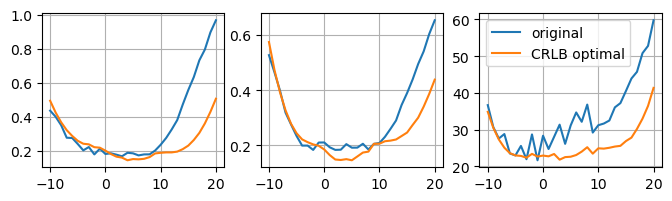

In [8]:
plt.figure(figsize=(8, 2))
plt.subplot(1, 3, 1)
plt.plot(zs.cpu()*1e3, crlb0.cpu()[:, 0])
plt.plot(zs.cpu()*1e3, crlb1.cpu()[:, 0])
plt.grid('on')
plt.subplot(1, 3, 2)
plt.plot(zs.cpu()*1e3, crlb0.cpu()[:, 1])
plt.plot(zs.cpu()*1e3, crlb1.cpu()[:, 1])
plt.grid('on')
plt.subplot(1, 3, 3)
plt.plot(zs.cpu()*1e3, crlb0.cpu()[:, 2])
plt.plot(zs.cpu()*1e3, crlb1.cpu()[:, 2])
plt.grid('on')
plt.legend(['original', 'CRLB optimal'])

plt.show()

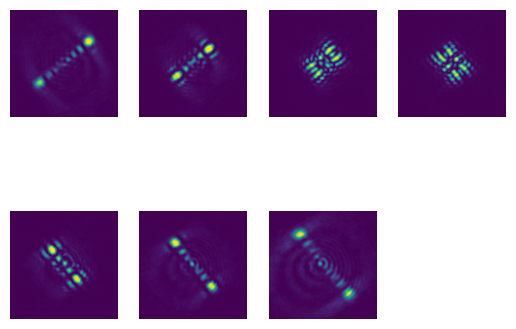

In [9]:
# measurement
zstack_exp = np.flip(tifffile.imread('.//data//1028.tif'), axis=0)
zstack_exp = np.flip(zstack_exp, axis=1)
zstack_exp = rotate(zstack_exp, 26.5, axes=(1, 2), reshape=False)
zstack_exp = zstack_exp/np.sum(zstack_exp, axis=(1, 2), keepdims=True)*1e4
zstack_exp_show = zstack_exp[1:-2, 20:-20, 20:-20][::2]
show_imset(zstack_exp_show)

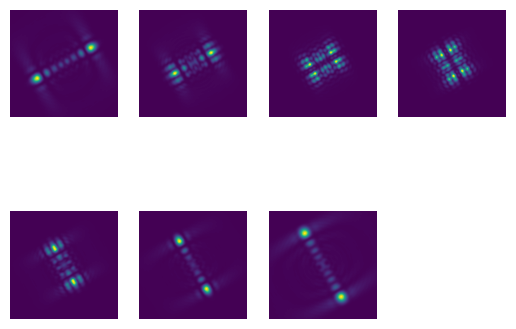

In [10]:
zs = torch.arange(zmin, zmax+1e-9, 2e-3, device=device)+2.4e-3
xyzs = zs.unsqueeze(1).repeat(1, 3)
xyzs[:, :2] = 0.0
with torch.set_grad_enabled(False):
    psfs_design = model(xyzs).cpu().numpy()[1:-2, 0, 20:-20, 20:-20][::2]
    
show_imset(psfs_design)
    

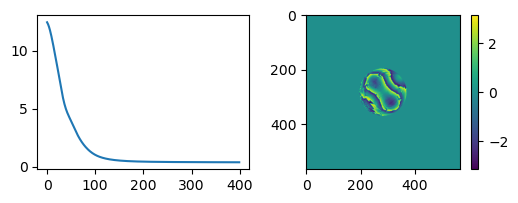

In [11]:
# phase retrieval
model.mask = torch.tensor(mask*0, device=device, requires_grad=True)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam([{'params':model.mask, 'lr':3e-2}])

y_target = torch.tensor(zstack_exp.astype(np.float32), device=device)

# phase retrieval
epoch_num = 400
epoch_loss = []
for epoch in range(epoch_num):
    psf = model(xyzs)
    loss = loss_func(psf[:, 0, :, :], y_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    epoch_loss.append(loss.item())


plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss)
plt.subplot(1, 2, 2)
mask2 = model.mask.detach().cpu().numpy()
mask2 = np.angle(np.exp(1j*mask2))*model.aper.cpu().numpy()
plt.imshow(mask2)
plt.colorbar()
plt.show()

In [12]:
with torch.set_grad_enabled(False):
    psfs = model(xyzs).cpu().numpy()[1:-2, 0, 20:-20, 20:-20][::2]

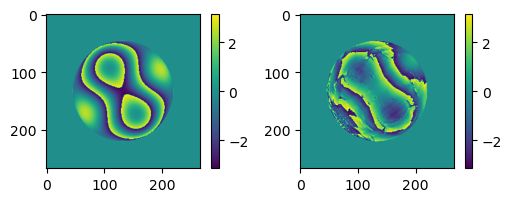

In [13]:
plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.imshow(phase_wrap)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(mask2[150:-150, 150:-150])
plt.colorbar()
plt.show()

In [14]:
sio.savemat('tp.mat', dict(phase1=phase_wrap, phase2=mask2[150:-150, 150:-150]))



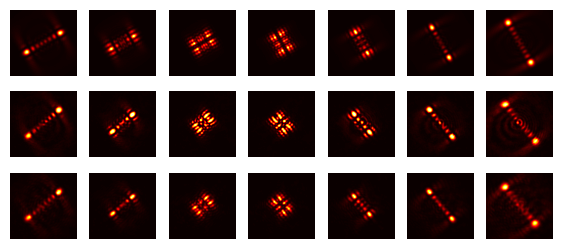

In [15]:
# plot model detection PSFs
fig = plt.figure(1, figsize=(7, 3))
gs = fig.add_gridspec(3, 7)
for i in range(7):
    ax1 = fig.add_subplot(gs[0, i]); ax1.imshow(psfs_design[i, :, :], cmap='hot'); ax1.axis('off');
    ax1 = fig.add_subplot(gs[1, i]); ax1.imshow(zstack_exp_show[i, :, :], cmap='hot'); ax1.axis('off');
    ax1 = fig.add_subplot(gs[2, i]); ax1.imshow(psfs[i, :, :], cmap='hot'); ax1.axis('off');

# plt.savefig('crlb_exp.jpg', bbox_inches='tight', dpi=600)
plt.show()